## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Install and Import necessary libraries**

In [115]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2

In [116]:
# Import Pandas: Used for data manipulation and analysis.
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

#Import NumPy: Used for numerical operations and array handling.
import numpy as np

# Matplotlib: Used for creating static, interactive, and animated visualizations.
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

# To build and evaluate ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Import TensorFLow and Keras for deep learning model building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the dataset**

In [117]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Dataset/stock_news.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Overview**

**Display the number of rows and columns**

In [118]:
# Show the number of rows and columns in the data
data.shape

(349, 8)

**Display the first 10 rows of the dataframe**

In [119]:
# Show first 10 columns of dataframe
data.head(10)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.24,41.48,40.25,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.24,41.48,40.25,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.24,41.48,40.25,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.74,42.24,41.48,40.25,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.24,41.48,40.25,130672400,-1
5,2019-01-02,Apple CEO Tim Cook discussed the company's Q1 ...,41.74,42.24,41.48,40.25,130672400,0
6,2019-01-02,Roku Inc has announced plans to offer premium...,41.74,42.24,41.48,40.25,130672400,1
7,2019-01-02,Wall Street saw modest gains on Wednesday but...,41.74,42.24,41.48,40.25,130672400,-1
8,2019-01-02,Apple's fiscal first quarter revenue came in ...,41.74,42.24,41.48,40.25,130672400,-1
9,2019-01-02,Apple Inc. lowered its quarterly sales foreca...,41.74,42.24,41.48,40.25,130672400,-1


**Display the data type of the columns**

In [120]:
# Show datatype of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


Date column is  of type object.

**Convert the data type of Date as date**

In [121]:
# Convert Date column datatype to date
data['Date'] = pd.to_datetime(data['Date'])

Display the statistical summary of data

In [122]:
# Show statistical summary of data. It is transposed to show the columns as rows.
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,349,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00,NaN
Open,349.00,46.23,37.57,41.74,45.97,50.71,66.82,6.44
High,349.00,46.70,37.82,42.24,46.03,50.85,67.06,6.51
Low,349.00,45.75,37.30,41.48,45.64,49.78,65.86,6.39
Close,349.00,44.93,36.25,40.25,44.60,49.11,64.81,6.40
Volume,349.00,128948236.10,45448000.00,103272000.00,115627200.00,151125200.00,244439200.00,43170314.92
Label,349.00,-0.05,-1.00,-1.00,0.00,0.00,1.00,0.72


* Data is from Jan 2019 - April 2019
* Between Jan 2019 - April 2019 the opening high was 66.82 and opening low was 37.57

*   The highest price was 67.06
*   The lowest price was 37.30






**Check for duplicates**

In [123]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]

# Print the number of duplicate rows
print(duplicate_rows)

Empty DataFrame
Columns: [Date, News, Open, High, Low, Close, Volume, Label]
Index: []


No duplicate rows

**Check for missing values**

In [124]:
# Check for missing values
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


No missing values

## **Exploratory Data Analysis**

### **Univariate Analysis**

* Distribution of individual variables
* Compute and check the distribution of the length of news content

Text(0.5, 1.0, 'Distribution of polarity of news')

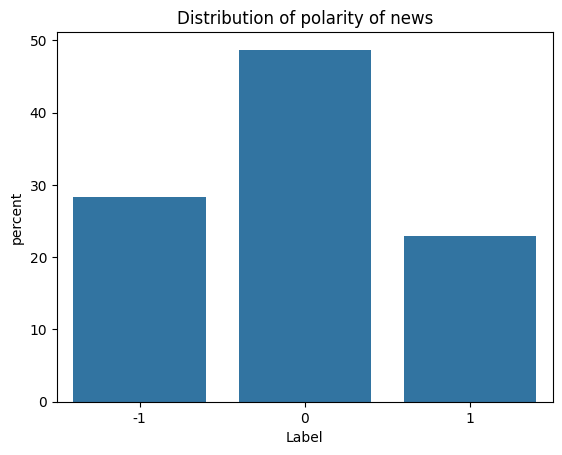

In [125]:
# Show the distribution of new polarity in percentage
sns.countplot(data=data, x='Label',stat="percent")
plt.title('Distribution of polarity of news')
#plt.show()

Graph shows that about 50% of the time, market was neutral to the market news.
About 28% of of the time, market behaved negatively to the market news.
And about 22% market was positive to the news.

**Density Plot Of Price (Open, High, Low, Close)**

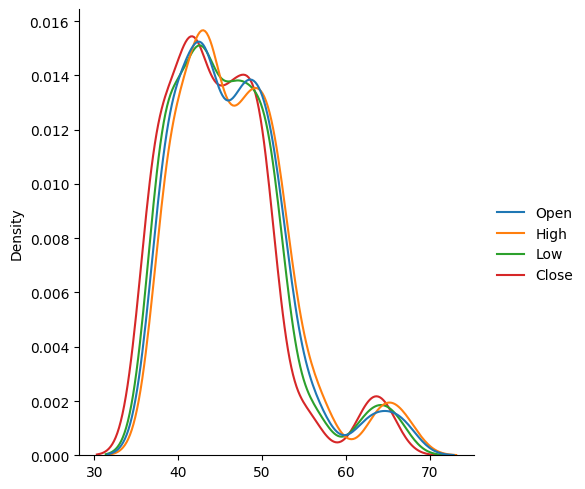

In [126]:
# Show the distribution of 4 stock price
sns.displot(data=data[['Open','High','Low','Close']], kind='kde',palette="tab10")


* All four prices show similar distribution peak ~40 -50 and another peak ~60 - 70
* Lines are so close, indicating low variance.

**Histogram on Volumn**

Text(0.5, 1.0, 'Histogram of Volumn')

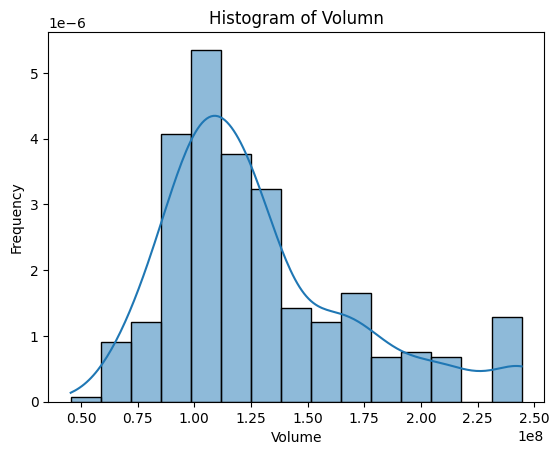

In [127]:
# Show the distribution of trading volumn
sns.histplot(data=data, x='Volume', kde=True, stat="frequency")
plt.title('Histogram of Volumn')

X-axis: Range of trading volumns.
Y-axis: No of times the trading volumns fell in the range bucket.
* Distribution is right skewed.
* Lower trading volumns are common
* There are some ouliers as high trading volumes on the right.
* Most days have low trading volumns. Some days have high trading volumn possibly due to the makert moving newes.


**Statistical Summary on News Length**

In [128]:
# Calulate the number of words in each new article
data['news_length'] = data['News'].apply(lambda x: len(x.split()))
data['news_length'].describe()

,news_length
count,349.00
mean,48.35
std,5.72
min,18.00
25%,45.00
50%,49.00
75%,52.00
max,60.00


* The average word count for each article is 48.35
* The minimum word count for each article is 18
* The max word count for each article is 60


**Histogram on News Length**

Text(0.5, 1.0, 'Histogram of Article Word Count')

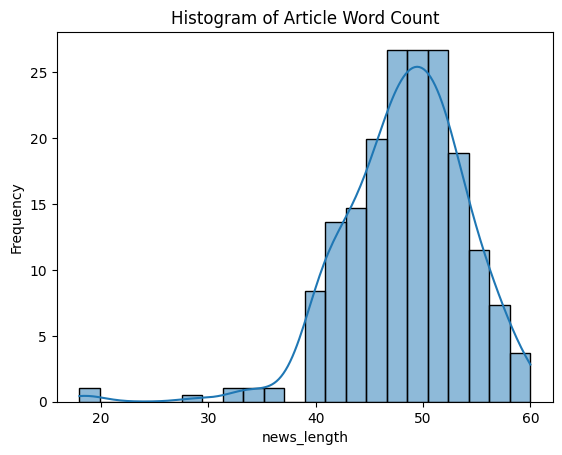

In [129]:
# Show the distribution of News word count
sns.histplot(data=data, x='news_length', kde=True, stat="frequency")
plt.title('Histogram of Article Word Count')

Histogram shows that:
* Most articles have word count between 45 - 55.
* Very few articles with low word count.


### **Bivariate Analysis**

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

**Correlation Heatmap**

<Axes: >

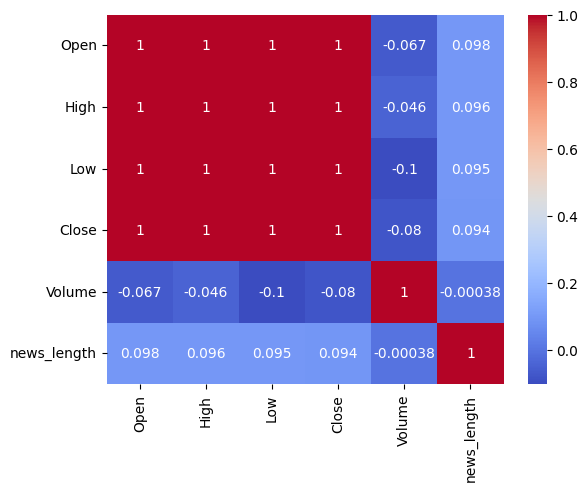

In [130]:
# Show the correlation between variables
cols= ['Open','High','Low','Close','Volume','news_length']
corr = data[cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

* There is a strong positive correlation between the open, high, low and close variable.
* News length has a weak correlation with the price variables. Meaning the length of the news has no effect on the price vairbles.
* Volumn also has a weak correlation to price variables.

**Box Plot between Label vs Price**


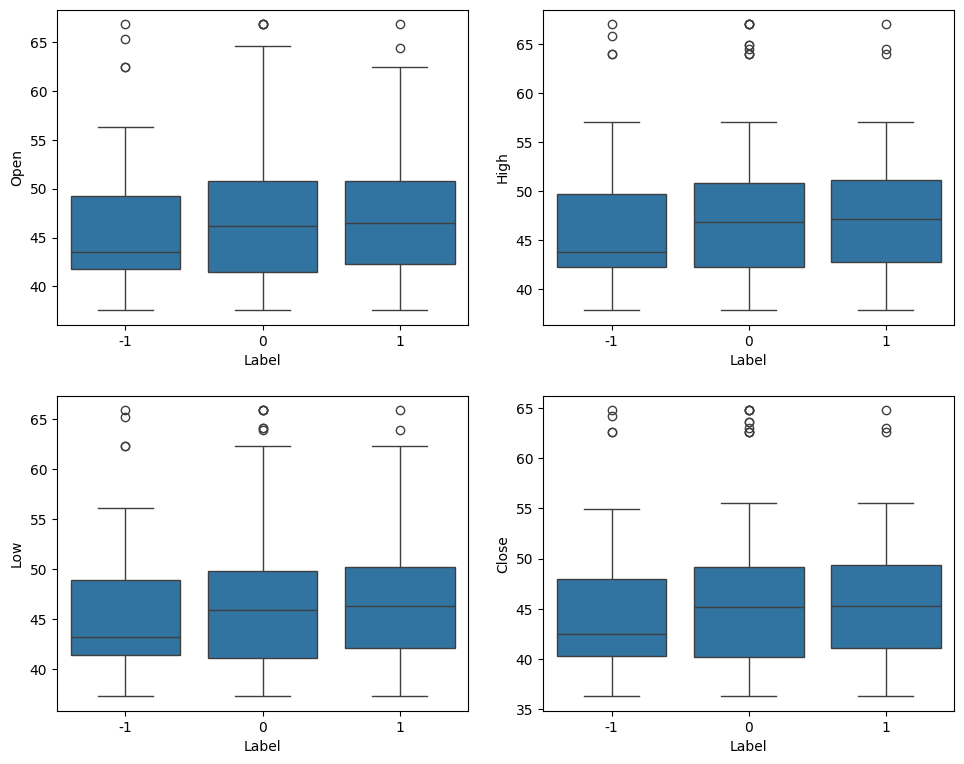

In [131]:
# Show box plot of label vs price
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=data, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

* Price distribution is similar across market polarity.
* Not much variation in price based on market sentiments.


**Date vs Price**

In [132]:
# Group data by date
data_daily = data.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()

data_daily.set_index('Date', inplace=True)
data_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.74,42.24,41.48,40.25,130672400.00
2019-01-03,43.57,43.79,43.22,42.47,103544800.00
2019-01-04,47.91,47.92,47.10,46.42,111448000.00
2019-01-07,50.79,51.12,50.16,49.11,109012000.00
2019-01-08,53.47,54.51,51.69,50.79,216071600.00


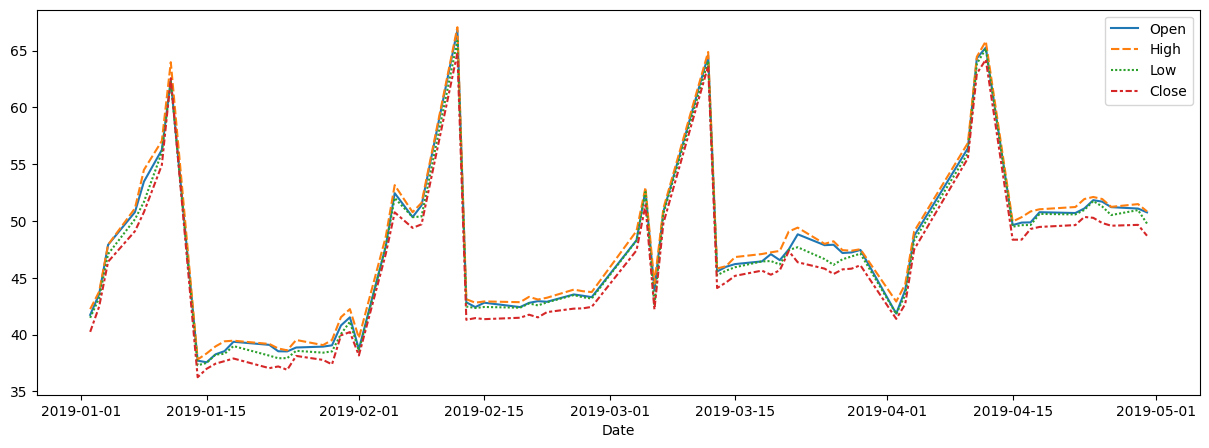

In [133]:
 # Show the line plot of price over time
plt.figure(figsize=(15,5))
sns.lineplot(data_daily.drop("Volume", axis=1)); #Complete the

* The 4 different prices move in sync, prices are on a given day are closely related
* There regular interval of highs and lows indicate periodic market events.


## **Data Preprocessing**

Transform raw data into a clean organized and usable format for models to learn.

In [134]:
# Check the date to figure out how to split the data
data['Date'].describe()

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


## **Train-Test Split**

Split data for training and test. Since time series data, train using data from 2019-01-02 - 2019-03-31. And test on April Data.

In [135]:
# Split data for train and test
X_train = data[data['Date'] < '2019-04-01']
X_test = data[data['Date'] >= '2019-04-01']

In [136]:
# Assign Label as target variable
y_train = X_train['Label'].copy()
y_test = X_test['Label'].copy()

In [137]:
#Check the shape of training and testing data to confirm split
print('Shape of training data:', X_train.shape)
print('Shape of testing data:', X_test.shape)
print('Shape of training target:', y_train.shape)
print('Shape of testing target:', y_test.shape)

Shape of training data: (286, 9)
Shape of testing data: (63, 9)
Shape of training target: (286,)
Shape of testing target: (63,)


##**Word Embeddings**
In this project we'll try Word2Vec-based model and Sentence Transformer-based model to generate the vector representation of stock metadata.

### **Text embedding using Word2Vec**

Step 1: Data Preparation

In [138]:
# Create data_word2vec to store tokens, embedding independently without modifying the original dataframe.
data_word2vec = data.copy()


In [139]:
# Using simple_preprocess function to tokenize and lowercase all words.
from gensim.utils import simple_preprocess
data_word2vec['tokens'] = data_word2vec['News'].apply(lambda x: simple_preprocess(x))


In [140]:
# Check the tokens
#print(data_word2vec['tokens'])

Step 2: Model Training

In [141]:
# Train the word2vec model preprocessed data. Tokenize and vectorize.
from gensim.models import Word2Vec
vec_size = 300
model_word2vec = Word2Vec(sentences=data_word2vec['tokens'], vector_size=vec_size, window=5, min_count=1, workers=4,seed=42)

In [189]:
# Check the tokens
#print(model_word2vec.wv.index_to_key)

Step 3: Create a Dictionary of words

In [143]:
# Create a list of all unique words the model has learned for embedding
words = list(model_word2vec.wv.index_to_key)
word_vectors = {word: model_word2vec.wv[word].tolist() for word in words}

Step 4: Average Vector Calculation

In [144]:
# Averaging the word vectors to get sentence encoding. Average all words in the new article to get a single fixed size vector.
def average_vector(doc):
    vectors = [word_vectors[word] for word in doc.split() if word in word_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vec_size)

In [145]:
# Creating a dataframe of the vectorized articles
X_train_wv = pd.DataFrame(X_train['News'].apply(average_vector).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vector).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])



In [146]:
# Check the shape of the data
print(X_train_wv.shape)
print(X_test_wv.shape)

(286, 300)
(63, 300)


### **Text embedding using Sentence Transformer**

**Define the Model**

In [147]:
# Define the model
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

**Encoding the data**

In [148]:
# Encoding the dataset
X_train_st = model.encode(X_train['News'].values, show_progress_bar=True)
X_test_st = model.encode(X_test['News'].values, show_progress_bar=True)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [149]:
# Check the shape of the dataframe
print(X_train_st.shape)
print(X_test_st.shape)

(286, 768)
(63, 768)


## **Sentiment Analysis**

#### **Model Evaluation Criterion**

##### **Utility Functions**

In [150]:
def plot_confusion_matrix(Actual, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(target, Actual)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix
    label_list = [0, 1,-1]

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

In [151]:
def model_performance_classification_sklearn(actual, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(target, actual)
    # Compute Recall
    recall = recall_score(target, actual,average='weighted')
    # Compute Precision
    precision = precision_score(target, actual,average='weighted')
    # Compute F1-score
    f1 = f1_score(target, actual,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

###**Build Random Forest Models using different text embeddings**


###**Build Random Forest Model using text embedding from Word2Vec**

In [152]:
# Build the Random Forest Model
# n_estimators: the number of trees in the forest
# max_depth: the maximum depth of each tree
# random_state: seed for random number generator
rf_wv = RandomForestClassifier(n_estimators=300,max_depth=3,random_state=42)
# Fit the model on training data
rf_wv.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=3, n_estimators=300, random_state=42)

**Check Training and Test Performance**

In [153]:
# Predicting on train data
y_pred_train = rf_wv.predict(X_train_wv)

# Predicting on test data
y_pred_test = rf_wv.predict(X_test_wv)

**Confusion Matrix**

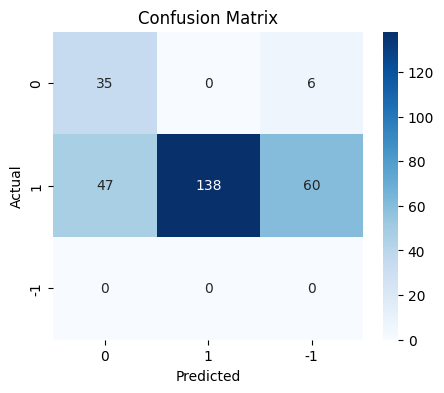

In [154]:
# Plot confusion matrix of train data
plot_confusion_matrix(y_train,y_pred_train)

* Model overpredicts positive sentiments.
* 47 actual positive sentiments were identified as neutral.
* 60 actual positive sentiments were identified as negative.
* Very few Negative sentiments were correctly identified as Negative. This suggests too few examples of negative sentiments in the training data.



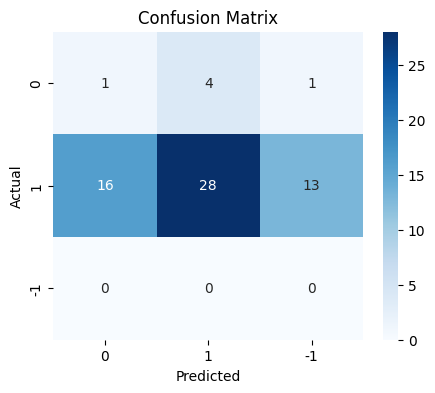

In [155]:
# Plot confusion matrix of test data
plot_confusion_matrix(y_test,y_pred_test)

* There are no predictions for negative sentiments. This means the model has failed to predict negative sentiments on unseen data.
* 16 positive sentiments misclassified as neutral sentiments
* 28 postive sentiments were corrctly identified as positive sentiments
* 13 positive sentiments were misclassified as negative sentiments.


**Classification Report**

In [156]:
# Calculate the key evaluation matrix on train data
rf_wv_train_performance = model_performance_classification_sklearn(y_pred_train, y_train)
print("rf_wv_Training_Performance:\n",rf_wv_train_performance)

# Calculate the key evaluation matrix on train data
rf_wv_test_performance = model_performance_classification_sklearn(y_pred_test, y_test)
print("rf_wv_Test_Performance:\n",rf_wv_test_performance)

rf_wv_Training_Performance:
    Accuracy  Recall  Precision   F1
0      0.60    0.60       0.52 0.51
rf_wv_Test_Performance:
    Accuracy  Recall  Precision   F1
0      0.46    0.46       0.29 0.34


**Training Performance:** Accuracy is 60% and precision is 52%. Suggesting better generalization.  
**Test Performance:** Accuracy of 46% and Precision is low 29%, meaning some predictions are incorrect.

**Tuning applied**
n_estimators = 300 and max_depth = 3
* rf_wv_Training_Performance:
* Accuracy = 60%
* Precision  = 52%
* F1 score = .51
* rf_wv_Test_Performance:
Accuracy = 46%
* Precision  = 29%
* F1 score = .34
--------------------------------------
n_estimators = 300 and max_depth = 5
* rf_wv_Training_Performance:
* Accuracy = 89%
* Precision  = 91%
* F1 score = .89
* rf_wv_Test_Performance:
* Accuracy = 43%
* Precision  = 27%
* F1 score = .33

--------------------------------------
n_estimators = 300 and max_depth = 7
* rf_wv_Training_Performance:
* Accuracy = 100%
* Precision  = 100%
* F1 score = 1
* rf_wv_Test_Performance:
* Accuracy = 46%
* Precision  = 32%
* F1 score = .36


Based on the hyperparameter tuning applied, a max depth of 3 and n_estimators = 300 seem to be more balanced and giving best generalization.

###**Build Random Forest Model using text embedding from Sentence Transformer**


In [157]:
# Build the model
rf_st = RandomForestClassifier(n_estimators=300,max_depth=5,random_state=42)
# Fit the model on training data
rf_st.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=5, n_estimators=300, random_state=42)

**Check Training and Test Performance**

In [158]:
# Predict on train data
y_pred_train = rf_st.predict(X_train_st)

# Predict on test data
y_pred_test = rf_st.predict(X_test_st)

**Confusion Matrix**

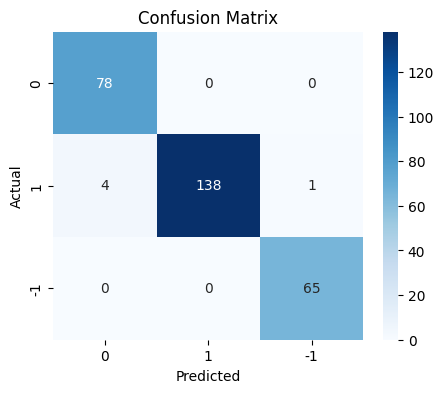

In [159]:
# Plot confusion matrix of train data
plot_confusion_matrix(y_train,y_pred_train)


* There is high accuracy in the classification of Neutral and negative sentiments on training data
* Most positive sentiments have also been correctly identified as positive


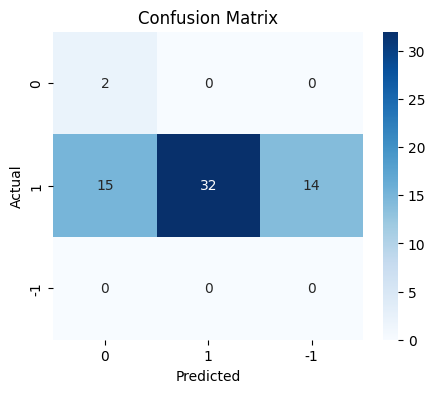

In [160]:
# Plot confusion matrix of test data
plot_confusion_matrix(y_test,y_pred_test)

* Neutral sentiments has been identified correctly as Neutral. But only very little data.
* No negative sentiments.
* Of the 61 positive sentiment, only 32 were correctly identified. So model struggles to learn for positive sentiments.
* This might be due to class imbalance, not having enough data in all classes.



**Classification Report**

In [161]:
# Calculate the key evaluation matrix on train data
rf_st_train_performance = model_performance_classification_sklearn(y_pred_train, y_train)
print("rf_st_Training_Performance:\n",rf_st_train_performance)

# Calculate the key evaluation matrix on test data
rf_st_test_performance = model_performance_classification_sklearn(y_pred_test, y_test)
print("rf_st_Test_Performance:\n",rf_st_test_performance)

rf_st_Training_Performance:
    Accuracy  Recall  Precision   F1
0      0.98    0.98       0.98 0.98
rf_st_Test_Performance:
    Accuracy  Recall  Precision   F1
0      0.54    0.54       0.54 0.41


**Training Performance**:
Accuracy is 98% and precision is 98%. Suggesting better generalization.

**Test Performance**: Accuracy of 54% and Precision is 54%, meaning some predictions are incorrect.


--------------------------------------
n_estimators = 300 and max_depth = 5
* rf_wv_Training_Performance:
* Accuracy = 98%
* Precision  = 98%
* F1 score = .98
* rf_wv_Test_Performance:
* Accuracy = 54%
* Precision  = 54%
* F1 score = .41
--------------------------------------
n_estimators = 300 and max_depth = 3
* rf_wv_Training_Performance:
* Accuracy = 69%
* Precision  = 80%
* F1 score = .65
* rf_wv_Test_Performance:
Accuracy = 52%
* Precision  = 53%
* F1 score = .38


--------------------------------------
n_estimators = 300 and max_depth = 7
* rf_wv_Training_Performance:
* Accuracy = 100%
* Precision  = 100%
* F1 score = 1
* rf_wv_Test_Performance:
* Accuracy = 54%
* Precision  = 54%
* F1 score = .41
--------------------------------------
n_estimators = 300 and max_depth = 10
Overfitting

### **Build Neural Network Models using different text embeddings**

###**Build Neural Network Model using text embedding from Word2Vec**

In [162]:
# Map the labels
label_mapping = {1: 2, 0: 1, -1: 0}

y_train_mapped_wv = y_train.map(label_mapping)
y_test_mapped_wv = y_test.map(label_mapping)

# Convert features Dataframe to a numpy array
X_train_wv_np = np.array(X_train_wv)
X_test_wv_np = np.array(X_test_wv)
y_train_mapped_wv = np.array(y_train_mapped_wv)
y_test_mapped_wv = np.array(y_test_mapped_wv)

In [163]:
# Check the shape after converting to array
print(X_train_wv_np.shape)
print(X_test_wv_np.shape)
print(y_train_mapped_wv.shape)
print(y_test_mapped_wv.shape)

(286, 300)
(63, 300)
(286,)
(63,)


In [164]:
# Check the number of features in the input vector
X_train_wv_np.shape[1]

300

In [165]:
import gc

# Clear tensorflow/keras previous session
tf.keras.backend.clear_session()
gc.collect()

# Define Model
model_wv = Sequential()

# Input Layer: Input layer units = number of features in your input vector = vec_size
model_wv.add(Dense(128, input_dim=vec_size, activation='relu'))

# Dropout layer: To reduce overfitting set the dropout rate between .2 - .5
model_wv.add(Dropout(0.3))

# Hidden Layer 1
model_wv.add(Dense(64, activation='relu'))
# Dropout layer: To reduce overfitting set the dropout rate between .2 - .5
model_wv.add(Dropout(0.3))

# Hidden Layer 2
model_wv.add(Dense(32, activation='relu'))

# Output Layer:
model_wv.add(Dense(3, activation='softmax'))

# Compile the model
model_wv.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model_wv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,963 (191.26 KB)

 Trainable params: 48,963 (191.26 KB)

 Non-trainable params: 0 (0.00 B)

In [166]:
# Fit model on training data
# - epochs: number of times the model will see the entire training data (typically 5 to 50)
# - batch_size: number of samples the model will process before updating weights (commonly 16 to 128)
history = model_wv.fit(
    X_train_wv_np, y_train_mapped_wv,
    validation_data=(X_test_wv_np, y_test_mapped_wv),
    epochs=10,
    batch_size=32
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4234 - loss: 1.0929 - val_accuracy: 0.5079 - val_loss: 1.0648
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5002 - loss: 1.0669 - val_accuracy: 0.5079 - val_loss: 1.0259
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4922 - loss: 1.0631 - val_accuracy: 0.5079 - val_loss: 1.0207
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4958 - loss: 1.0593 - val_accuracy: 0.5079 - val_loss: 1.0267
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5235 - loss: 1.0235 - val_accuracy: 0.5079 - val_loss: 1.0235
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4472 - loss: 1.0779 - val_accuracy: 0.5079 - val_loss: 1.0318
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4590 - loss: 1.0600 - val_accuracy: 0.5079 - val_loss: 1.0286
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4623 - loss: 1.0713 - val_accuracy: 0.5079 - val_loss: 1.0271


**Check Training and Test Performance**

In [167]:
# Predict probabilities on training data
y_train_pred_probs = model_wv.predict(X_train_wv_np)

# Convert probabilities to labels
y_train_preds = tf.argmax(y_train_pred_probs, axis=1).numpy()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [168]:
# Predict probabilities on test data
y_test_pred_probs = model_wv.predict(X_test_wv_np)

# Convert probabilities to labels
y_test_preds = tf.argmax(y_test_pred_probs, axis=1).numpy()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [169]:
# Convert back to [-1, 0, 1] to match utility function expectations
label_mapping = {2: 1, 1: 0, 0: -1}

y_train_preds = np.array([label_mapping[index] for index in y_train_preds])
y_test_preds = np.array([label_mapping[index] for index in y_test_preds])

**Confusion Matrix**

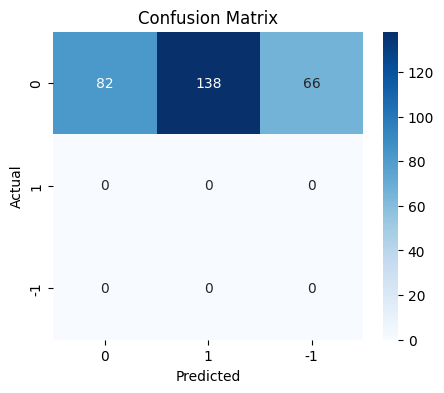

In [170]:
# Plot confusion matrix for train data
plot_confusion_matrix(y_train_mapped_wv,y_train_preds)

* Only the Neutral sentiments are being predicted correctly.
* Model failed to predict Positive and Negative sentiments.

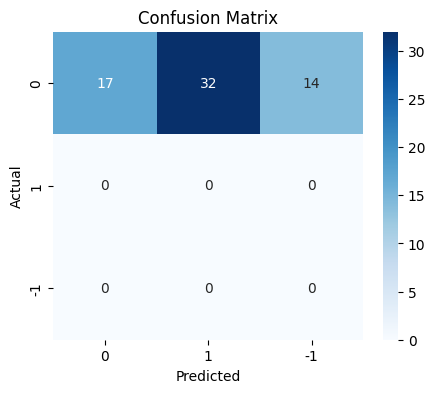

In [171]:
# Plot confusion matrix for test data
plot_confusion_matrix(y_test_mapped_wv,y_test_preds)

* Only the Neutral sentiments are being predicted correct on the test data, classifying everything as neutral.
* Model failed to predict positive and negative for test data.

**Classification Report**

In [172]:
# Calculate the key evaluation matrix on train data
NN_train_wv_performance = model_performance_classification_sklearn(y_train_preds, y_train_mapped_wv)
print("NN_train_wv_performance:\n",NN_train_wv_performance)

# Calculate the key evaluation matrix on test data
NN_test_wv_performance = model_performance_classification_sklearn(y_test_preds, y_test_mapped_wv)
print("NN_test_wv_performance:\n",NN_test_wv_performance)

NN_train_wv_performance:
    Accuracy  Recall  Precision   F1
0      0.29    0.29       0.08 0.13
NN_test_wv_performance:
    Accuracy  Recall  Precision   F1
0      0.27    0.27       0.07 0.11


**Training data**: Model is performing poor on train data. Model struggles to learn meaningful patterns.
Accuracy - 29%
Precision - 29%
F1-Score - .13

**Test Data:** Model is performing poor on test data also. Model struggle sto learn meaningful patterns.
Accuracy - 27%
Precision - 27%
F1-Score - .11

###**Build Neural Network Model using text embedding from Sentence Transformer**

In [190]:
# Map labels
label_mapping = {1:2,0:1,-1:0}

y_train_mapped_st = y_train.map(label_mapping)
y_test_mapped_st = y_test.map(label_mapping)

# Convert features Dataframe to a numpy array
X_train_st_np = np.array(X_train_st)
X_test_st_np = np.array(X_test_st)
y_train_mapped_st = np.array(y_train_mapped_st)
y_test_mapped_st = np.array(y_test_mapped_st)

In [191]:
from collections import Counter

# Count the frequency of each label
label_counts = Counter(y_train_mapped_st)

# Print the results
for label, count in label_counts.items():
    print(f"Label {label}: {count} occurrences")


Label 0: 82 occurrences
Label 1: 138 occurrences
Label 2: 66 occurrences


This shows that the dataset is imbalanced. Positive snetiments out number the other two sentiments.

In [192]:
# Check shape after converting to array
print(X_train_st_np.shape)
print(X_test_st_np.shape)
print(y_train_mapped_st.shape)
print(y_test_mapped_st.shape)

(286, 768)
(63, 768)
(286,)
(63,)


In [193]:
# Check the number of features in the input vector
X_train_st_np.shape[1]

768

In [194]:
from sklearn.utils.class_weight import compute_class_weight
# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_mapped_st),
    y=y_train_mapped_st
)
# Convert to Dict
Class_weight_dict = dict(enumerate(class_weights))
Class_weight_dict

{0: 1.1626016260162602, 1: 0.6908212560386473, 2: 1.4444444444444444}

In [195]:
import gc

# Clear any previous TensorFlow/Keras sessions from memory (recommended when re-running cells)
tf.keras.backend.clear_session()
gc.collect()

# Define the model
model_st = Sequential()

# Input layer: input later size is shape of input data
model_st.add(Dense(256, input_dim=768, activation='relu'))

# Dropout layer: To reduce overfitting set the dropout rate between .2 - .5
model_st.add(Dropout(0.4))

# Hidden Layer 1
model_st.add(Dense(128, activation='relu'))
# Dropout layer: To reduce overfitting set the dropout rate between .2 - .5
model_st.add(Dropout(0.3))

# Hidden Layer 2
#model_st.add(Dense(32, activation='relu'))
# Dropout layer: To reduce overfitting set the dropout rate between .2 - .5

# Output Layer:
model_st.add(Dense(3, activation='softmax'))

# Compile the model
model_st.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model_st.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,147 (899.01 KB)

 Trainable params: 230,147 (899.01 KB)

 Non-trainable params: 0 (0.00 B)

In [210]:
# Fit model on training data
# class weights applied o address imbalnce of data
history = model_st.fit(
    X_train_st_np, y_train_mapped_st,
    validation_data=(X_test_st_np, y_test_mapped_st),
    epochs=10,
    batch_size=32,
    class_weight=Class_weight_dict
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9814 - loss: 0.1242 - val_accuracy: 0.3810 - val_loss: 1.6417
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9664 - loss: 0.1209 - val_accuracy: 0.4603 - val_loss: 1.7135
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9921 - loss: 0.0632 - val_accuracy: 0.4444 - val_loss: 1.7785
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9889 - loss: 0.0896 - val_accuracy: 0.4444 - val_loss: 1.8401
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9888 - loss: 0.0738 - val_accuracy: 0.4603 - val_loss: 1.8703
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9615 - loss: 0.0873 - val_accuracy: 0.4286 - val_loss: 1.9619
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9989 - loss: 0.0475 - val_accuracy: 0.3968 - val_loss: 2.0033
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9897 - loss: 0.0451 - val_accuracy: 0.4127 - val_loss: 2.0494


**Check Training and Test Performance**

In [211]:
# Predict probabilities on training data
y_train_pred_probs = model_st.predict(X_train_st_np)

# Convert probabilities to labels
y_train_preds = tf.argmax(y_train_pred_probs, axis=1).numpy()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [212]:
# Predict probabilities on test data
y_test_pred_probs = model_st.predict(X_test_st_np)

# Convert probabilities to labels
y_test_preds = tf.argmax(y_test_pred_probs, axis=1).numpy()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [213]:
# Convert back to [-1, 0, 1] to match utility function expectations
#label_mapping = {2:1,1:0,0:-1}

#y_train_preds = np.array([label_mapping[index] for index in y_train_preds])
#y_test_preds = np.array([label_mapping[index] for index in y_test_preds])



In [214]:

from collections import Counter

# Replace this with your actual predictions
# y_train_preds = np.array([...])

# Count the frequency of each label
label_counts = Counter(y_train_preds)

# Print the results
for label, count in label_counts.items():
    print(f"Label {label}: {count} occurrences")


Label 0: 82 occurrences
Label 1: 138 occurrences
Label 2: 66 occurrences


**Confusion Matrix**

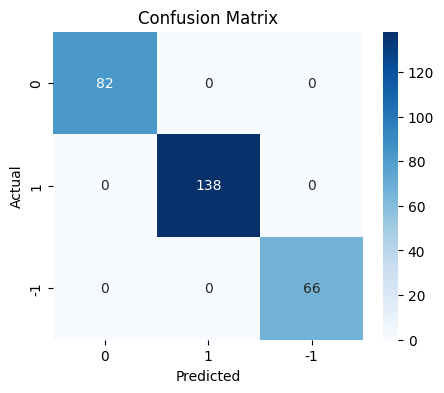

In [215]:
# Plot confusion matrix for train data
plot_confusion_matrix(y_train_mapped_st,y_train_preds)
#plot_confusion_matrix(y_train,y_train_preds)

* Model performs better diagonally.
* Neutral and Negative also has the most misclassifications.
* Model has strong classification performance.

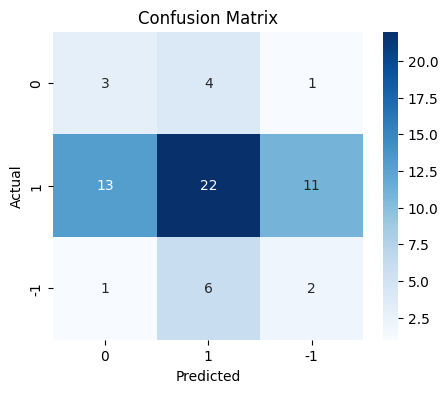

In [216]:
# Plot confusion matrix for test data
plot_confusion_matrix(y_test_mapped_st,y_test_preds)


* Model predicts better for positive sentiments. But there are misclassifications.
* There is misclassifications of positive sentiments to other categories.
* Negative sentiments have many misclassifictaions.
* Model has class imbalance.

**Classification Report**

In [217]:
# Calculate the key evaluation matrix on train data
NN_train_st_performance = model_performance_classification_sklearn(y_train_preds, y_train_mapped_st)
print("NN_train_st_performance:\n",NN_train_st_performance)

# Calculate the key evaluation matrix on test data
NN_test_st_performance = model_performance_classification_sklearn(y_test_preds, y_test_mapped_st)
print("NN_test_st_performance:\n",NN_test_st_performance)

NN_train_st_performance:
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00
NN_test_st_performance:
    Accuracy  Recall  Precision   F1
0      0.43    0.43       0.39 0.39


Training data: Model is performing with high accuracy on train data.
Accuracy - 100% Precision - 100% F1-Score - 1

Test Data: Model is showing a moderate perofmance on test data also.
Accuracy - 43% Precision - 43% F1-Score - .39

### **Model Performance Summary and Final Model Selection**

In [218]:
# Concat the training performance matrix from different models
# Transpose performance dataframe to make metric as rows
model_train_performance = pd.concat(
                            [
                            rf_wv_train_performance.T, # Random Forest using Word2Vec embeddings
                            rf_st_train_performance.T, # Random Forest with Sentence Transformer embeddings
                            NN_train_wv_performance.T, # Neural Network with Word2Vec embeddings
                            NN_train_st_performance.T  # Neural Network with Sentence Tranformer embeddings
                            ],axis=1)
# Assign columns names for the performance matrix
model_train_performance.columns = [
                            'rf_wv_Training_Performance',
                            'rf_st_Training_Performance',
                            'NN_wv_Training_Performance',
                            'NN_st_Training_Performance'
                          ]
# Print the training performance matrix
print("model_train_performance:\n",model_train_performance)


model_train_performance:
            rf_wv_Training_Performance  rf_st_Training_Performance  \
Accuracy                         0.60                        0.98   
Recall                           0.60                        0.98   
Precision                        0.52                        0.98   
F1                               0.51                        0.98   

           NN_wv_Training_Performance  NN_st_Training_Performance  
Accuracy                         0.29                        1.00  
Recall                           0.29                        1.00  
Precision                        0.08                        1.00  
F1                               0.13                        1.00  


**rf_st_Training_Performance** and **NN_st_Training_Performance** :
- Has the best overall performance.
- Shows high accuracy, precision and recall.
- But sometime such high score can lead to overfitting

**rf_wv_Training_Performance**
- Perform moderately well with Accuracy of 60%, Recall 60% and Precision of .52
- Balanced recall and F1 score suggest more generalization.

**NN_wv_Training_Performance**
- Poor performance on traing data.
- Model struggles to learn.


In [220]:
# Concat the testing performance matrix from different models
# Transpose performance dataframe to make metric as rows
model_test_performance = pd.concat(
                            [
                            rf_wv_test_performance.T, # Random Forest using Word2Vec embeddings
                            rf_st_test_performance.T, # Random Forest with Sentence Transformer embeddings
                            NN_test_wv_performance.T, # Neural Network with Word2Vec embeddings
                            NN_test_st_performance.T  # Neural Network with Sentence Tranformer embeddings
                            ],axis=1)
# Assign columns names for the performance matrix
model_test_performance.columns = [
                            'rf_wv_Test_Performance',
                            'rf_st_Test_Performance',
                            'NN_wv_Test_Performance',
                            'NN_st_Test_Performance'
                          ]
# Print the testing performance matrix
print("model_test_performance:\n",model_test_performance)

model_test_performance:
            rf_wv_Test_Performance  rf_st_Test_Performance  \
Accuracy                     0.46                    0.54   
Recall                       0.46                    0.54   
Precision                    0.29                    0.54   
F1                           0.34                    0.41   

           NN_wv_Test_Performance  NN_st_Test_Performance  
Accuracy                     0.27                    0.43  
Recall                       0.27                    0.43  
Precision                    0.07                    0.39  
F1                           0.11                    0.39  


**rf_st_Test_Performance** :
- Has the best overall performance.
- Shows high accuracy 54%, precision 54% and recall .54
- No signs of overfitting despite the high training score.

**rf_wv_Test_Performance**
- Perform moderately well with Accuracy of 46%, Recall 46%
- But Precision is 29%

**NN_st_Test_Performance**
- It is performing better that NN Word2Vec model.
- Accuracy of 43% , Precision 43% and F1 score .39 suggest underfitting.

**NN_wv_Test_Performance**
- Poor performance on test data also.
- Model struggles to learn or is underfitting.

## **Conclusions and Recommendations**

**Conclusion**
- **1. Best Performing Model (Test Set):**
  * **Random Forest with Sentence Transformer Embeddings**

    - Test Accuracy: 54%
    - Test F1 Score: 0.41
    - This model performs best overall and is not over fitting despite high training scores.
- **2. 2nd Best Performing Model:**
  * **Random Forest with Word2Vec**
    -  Random Forest with Word2Vec: 60% training accuracy vs 43% test accuracy

- **3. Neural Network Models Underperformed**
  - Though NN_ST has high accuracy on training data, test data suggest underfitting.
  - NN_W2V show extremely poor accuracy and F1 scores, even on training data. This indicates:
    - Not enough data to effectively train NN (deep models usually need more samples)
    - Possibly poor hyperparameter settings

**Recommendation**
- Use Random Forest + Sentence Transformer Embeddings as the primary model for predicting the market sentiment for the start up. As this model is consistent in performance across training and test sets.

**Steps taken to improve accuracy**:
- Attempted to tune Hyperparameters of Random Forest:
  * Max_depth to 7 was tried, but the model was overfitting.
  * n_estimators up to 300 was tried. May be can increase up to 500 .
  * Attempeted to improve neural network performance by using weighted class to avoid data imbalance.







-

<font size=6 color='blue'>Power Ahead</font>
___